# Kaggle course : feature engineering

For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear models, for instance, are only able to learn linear relationships.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import cv2

In [2]:
from sklearn.feature_selection import mutual_info_regression

### Mutal information 


The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

<br />

<li>MI can help you to understand the <strong>relative potential of a feature</strong> as a predictor of the target, considered by itself.</li>
<li>It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a <strong>univariate</strong> metric.</li>
<li>The actual <strong>usefulness of a feature depends on the model you use it with</strong>. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.</li>

The scikit-learn mutal information algorithm treats discrete features differently from continuous features:
<li>anything that must have a float dtype is not discrete</li>
<li>'object' or 'categorical' dtype can be treated as discrete using label encoding</li>

In [3]:
def make_mi_scores(X, y, discrete_features):
    # mutual_info_regression and mutual_info_classification
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

## Principal component analysis


This, in fact, is the whole idea of PCA: <em>"instead of describing the data with the original features, we describe it with its axes of variation"</em>
<br>
Technical note: PCA is typically applied to standardized data (data where the mean is zero and the standard deviation is 1)

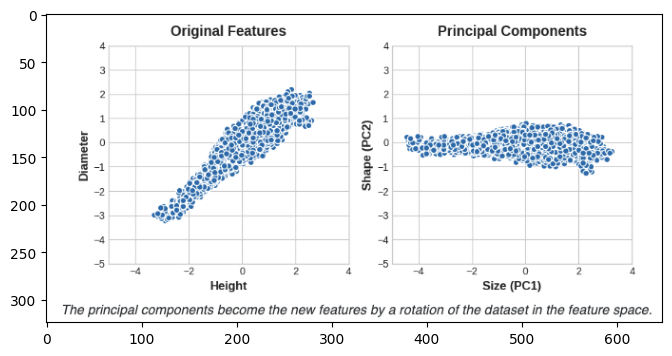

In [18]:
plt.figure(figsize=(12,4))
img = plt.imread("images/pca.png")
plt.imshow(img)

<em>The new features PCA constructs are actually just linear combinations (weighted sums) of the original features</em>
<ul>
    <li>These new features are called the principal components of the data.</li>
    <li>The weights themselves are called loadings.</li>
</ul>

### PCA for feature engineering

There are two ways you could use PCA for feature engineering.<br>

<ol>
    <li>The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.</li><br>
    <li>The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:
        <ul>
            <li>Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.</li>
            <li>Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.</li>
            <li>Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.</li>
            <li>Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.</li>
        </ul>
    </li>
</ol>